In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns



import torch.nn.functional as F


from sklearn.decomposition import PCA

import model

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)

# Import the data

In [3]:
### Download the data and create dataset
data_dir = '../dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=False)

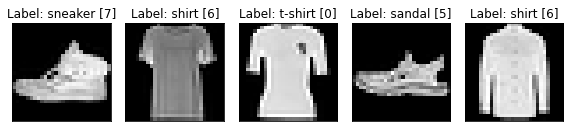

In [4]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(1, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [5]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Implement autoencoder

In [7]:
encoded_space_dim = 2
max_epochs     = 10
learning_rate  = 0.0067
regularization = 0.

In [8]:
# Initialize the autoencoder
AE = model.Autoencoder(encoded_space_dim)

In [9]:
### Define the loss function for reconstruction
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


EPOCH 1/10
AVERAGE TRAIN LOSS: 0.056948330253362656
AVERAGE TEST LOSS: 0.04278302192687988


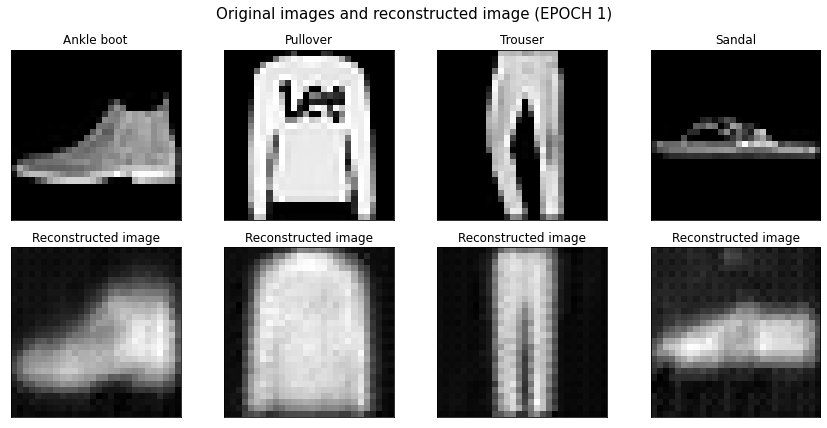

EPOCH 2/10
AVERAGE TRAIN LOSS: 0.035625945776700974
AVERAGE TEST LOSS: 0.03422710672020912
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03411194682121277
AVERAGE TEST LOSS: 0.035095106810331345
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.031979817897081375
AVERAGE TEST LOSS: 0.03177774325013161
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.031079646199941635
AVERAGE TEST LOSS: 0.030783887952566147
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.03070054017007351
AVERAGE TEST LOSS: 0.030676281079649925


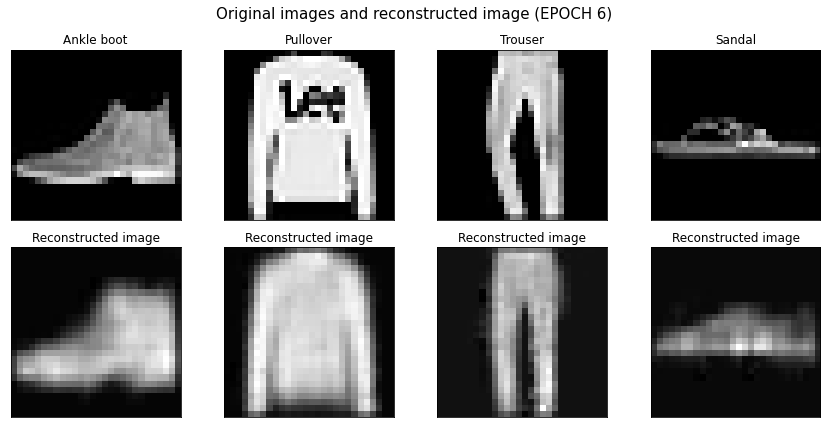

EPOCH 7/10
AVERAGE TRAIN LOSS: 0.03037051483988762
AVERAGE TEST LOSS: 0.03021874465048313
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.030509203672409058
AVERAGE TEST LOSS: 0.030114715918898582
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.03001955710351467
AVERAGE TEST LOSS: 0.029605621472001076
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.02951187454164028
AVERAGE TEST LOSS: 0.029525846242904663


In [10]:
train, test = AE.training_cycle(AE.encoder,
                                AE.decoder,
                                device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optim,
                                max_epochs,
                                test_dataset,
                                plot = True)

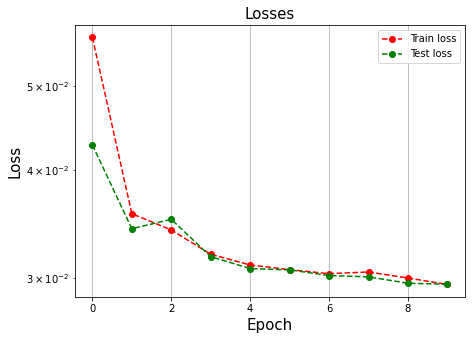

In [11]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Optimize autoencoder parameters

In [12]:
def objective(trial):
    max_epochs = 10
    
    # Parameters for the search
    encoded_space_dim      = trial.suggest_categorical("encoded_space_dim", [2,10])
    optimizer_name         = trial.suggest_categorical('optimizer_name',["SGD", "Adam"])
    lr                     = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    regularization         = trial.suggest_loguniform("regularization", 1e-5, 1e-1)
    
    
    ### Initialize both network
    AE = model.Autoencoder(encoded_space_dim)
    AE.to(device)
 
    
    ### Define the loss function
    loss_fn = torch.nn.MSELoss()
    
    
    #Define the optimizer
    optimizer = getattr(torch.optim,optimizer_name)(AE.parameters(), lr=lr, weight_decay=regularization)

    ################################################################################################
    # Train a model (cant use the function because I would need the separated parts encoder decoder)
    for epoch in range(max_epochs):
        print('EPOCH %d/%d' % (epoch + 1, max_epochs))
        ### Training (use the training function)
        # Set train mode for both networks
        AE.train()  
        train_loss = []
        
        # Train
        for sample_batched, _ in train_dataloader:
            # Move data to device
            sample_batched = sample_batched.to(device)
            # Encode decode the data
            encoded_decoded_sample = AE(sample_batched)
            loss = loss_fn(encoded_decoded_sample, sample_batched)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            #Save trai loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        #Save the average train loss
        train_loss = np.mean(train_loss)
        print(f"AVERAGE TRAIN LOSS: {train_loss}")
   
        ### Validation  (use the testing function)
        # Set evaluation mode for both networks
        AE.eval()
        test_loss = []
        # Discable gradient tracking
        with torch.no_grad():
            for sample_batched, _ in test_dataloader:
                # Move data to device
                sample_batched = sample_batched.to(device)
                # Encode decode the data
                encoded_decoded_sample = AE(sample_batched)
                # Compute loss
                loss = loss_fn(encoded_decoded_sample, sample_batched)
                 #Save test loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                test_loss.append(loss_batch)
            #Save the average train loss
            test_loss = np.mean(test_loss)
            print(f"AVERAGE TEST LOSS: {test_loss}")    
    
    
    return test_loss

In [13]:
#Define the study
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize")
study.optimize(objective, n_trials=50, timeout=14400) #six hours

[I 2022-06-30 00:09:01,005] A new study created in memory with name: myfirstoptimizationstudy


EPOCH 1/10
AVERAGE TRAIN LOSS: 0.0924815908074379
AVERAGE TEST LOSS: 0.0398736298084259
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03780230134725571
AVERAGE TEST LOSS: 0.03741099685430527
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03598584234714508
AVERAGE TEST LOSS: 0.03549104928970337
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.034946173429489136
AVERAGE TEST LOSS: 0.03467832878232002
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.03408950939774513
AVERAGE TEST LOSS: 0.0339861735701561
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.033456407487392426
AVERAGE TEST LOSS: 0.033493950963020325
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.03290967270731926
AVERAGE TEST LOSS: 0.033539436757564545
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.03245922923088074
AVERAGE TEST LOSS: 0.03247123211622238
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.03211471810936928
AVERAGE TEST LOSS: 0.03192921727895737
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.03171699121594429


[I 2022-06-30 00:13:24,620] Trial 0 finished with value: 0.031667303293943405 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'Adam', 'lr': 0.0013673897832202954, 'regularization': 0.00013252450320798488}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.031667303293943405
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.2839103937149048
AVERAGE TEST LOSS: 0.1755606234073639
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.14840708673000336
AVERAGE TEST LOSS: 0.13255153596401215
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12952899932861328
AVERAGE TEST LOSS: 0.12659874558448792
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12673527002334595
AVERAGE TEST LOSS: 0.1255558431148529
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12613537907600403
AVERAGE TEST LOSS: 0.12519490718841553
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12584282457828522
AVERAGE TEST LOSS: 0.1249600499868393
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12562929093837738
AVERAGE TEST LOSS: 0.12477479875087738
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12545809149742126
AVERAGE TEST LOSS: 0.12462069094181061
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12530012428760529
AVERAGE TEST LOSS: 0.12449045479297638
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.1252015233039856


[I 2022-06-30 00:18:05,307] Trial 1 finished with value: 0.12437982857227325 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.0019829577395431685, 'regularization': 1.9889751322650513e-05}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.12437982857227325
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.1259983479976654
AVERAGE TEST LOSS: 0.1250516027212143
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.12566381692886353
AVERAGE TEST LOSS: 0.1247534304857254
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12535499036312103
AVERAGE TEST LOSS: 0.12452416121959686
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12518957257270813
AVERAGE TEST LOSS: 0.12434546649456024
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.1250363290309906
AVERAGE TEST LOSS: 0.12420690059661865
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12491586804389954
AVERAGE TEST LOSS: 0.12409599125385284
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12482348829507828
AVERAGE TEST LOSS: 0.12401113659143448
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12472661584615707
AVERAGE TEST LOSS: 0.1239548921585083
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12467896193265915
AVERAGE TEST LOSS: 0.12390711158514023
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12464385479688644


[I 2022-06-30 00:21:47,526] Trial 2 finished with value: 0.12387204170227051 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.0016862214020152077, 'regularization': 0.00025447646401617705}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.12387204170227051
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.22931385040283203
AVERAGE TEST LOSS: 0.1873914897441864
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.16673840582370758
AVERAGE TEST LOSS: 0.14965571463108063
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.1420382261276245
AVERAGE TEST LOSS: 0.13474300503730774
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.13217997550964355
AVERAGE TEST LOSS: 0.1288028061389923
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12826509773731232
AVERAGE TEST LOSS: 0.1263933628797531
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12661385536193848
AVERAGE TEST LOSS: 0.12538157403469086
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12593974173069
AVERAGE TEST LOSS: 0.12492666393518448
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.1255858838558197
AVERAGE TEST LOSS: 0.12470026314258575
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.1254141479730606
AVERAGE TEST LOSS: 0.12456865608692169
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.1253119558095932


[I 2022-06-30 00:25:13,166] Trial 3 finished with value: 0.12447985261678696 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.0009634099294649694, 'regularization': 0.003968297037921405}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.12447985261678696
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.12676134705543518
AVERAGE TEST LOSS: 0.12591800093650818
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.12674053013324738
AVERAGE TEST LOSS: 0.12588097155094147
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12666669487953186
AVERAGE TEST LOSS: 0.12584462761878967
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12666794657707214
AVERAGE TEST LOSS: 0.12580880522727966
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12659136950969696
AVERAGE TEST LOSS: 0.12577363848686218
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12657487392425537
AVERAGE TEST LOSS: 0.12573906779289246
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.1265508234500885
AVERAGE TEST LOSS: 0.1257050335407257
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12652356922626495
AVERAGE TEST LOSS: 0.12567156553268433
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12648960947990417
AVERAGE TEST LOSS: 0.1256386935710907
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12643124163150787


[I 2022-06-30 00:28:49,908] Trial 4 finished with value: 0.12560641765594482 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 1.7636262490508095e-05, 'regularization': 2.3656376948398793e-05}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.12560641765594482
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.13782235980033875
AVERAGE TEST LOSS: 0.12398989498615265
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.12477266788482666
AVERAGE TEST LOSS: 0.12396760284900665
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12476448714733124
AVERAGE TEST LOSS: 0.12396812438964844
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.1247606873512268
AVERAGE TEST LOSS: 0.12397279590368271
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12473917007446289
AVERAGE TEST LOSS: 0.12397155910730362
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12476350367069244
AVERAGE TEST LOSS: 0.12395849078893661
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12474863231182098
AVERAGE TEST LOSS: 0.12398231029510498
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12474668025970459
AVERAGE TEST LOSS: 0.123970627784729
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12472859025001526
AVERAGE TEST LOSS: 0.12401209771633148
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12478067725896835


[I 2022-06-30 00:33:24,777] Trial 5 finished with value: 0.12398405373096466 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.015772464247952696, 'regularization': 0.08234323487208123}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.12398405373096466
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.26676157116889954
AVERAGE TEST LOSS: 0.22602573037147522
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.20120255649089813
AVERAGE TEST LOSS: 0.17872515320777893
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.16577018797397614
AVERAGE TEST LOSS: 0.15324029326438904
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.1466628760099411
AVERAGE TEST LOSS: 0.13955992460250854
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.13645704090595245
AVERAGE TEST LOSS: 0.1322389394044876
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.1309555470943451
AVERAGE TEST LOSS: 0.12831568717956543
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.1280270218849182
AVERAGE TEST LOSS: 0.12619492411613464
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12636853754520416
AVERAGE TEST LOSS: 0.12504243850708008
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12550564110279083
AVERAGE TEST LOSS: 0.12440013885498047
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12494641542434692


[I 2022-06-30 00:38:46,720] Trial 6 finished with value: 0.1240350753068924 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.000553067542913729, 'regularization': 8.131169268459472e-05}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.1240350753068924
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.2546623945236206
AVERAGE TEST LOSS: 0.240505650639534
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.1806500256061554
AVERAGE TEST LOSS: 0.12369176000356674
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.1013072207570076
AVERAGE TEST LOSS: 0.08722417056560516
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.0813501849770546
AVERAGE TEST LOSS: 0.07669004052877426
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.0741441622376442
AVERAGE TEST LOSS: 0.07202722132205963
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.07082939893007278
AVERAGE TEST LOSS: 0.06973756104707718
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.06900245696306229
AVERAGE TEST LOSS: 0.06827698647975922
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.06751925498247147
AVERAGE TEST LOSS: 0.06652848422527313
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.06495481729507446
AVERAGE TEST LOSS: 0.0628051608800888
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.05909750983119011


[I 2022-06-30 00:44:20,707] Trial 7 finished with value: 0.055238645523786545 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'Adam', 'lr': 2.1147626236670562e-05, 'regularization': 1.6473826348182308e-05}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.055238645523786545
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.12484778463840485
AVERAGE TEST LOSS: 0.12438801676034927
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.1248718649148941
AVERAGE TEST LOSS: 0.12390005588531494
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12491793185472488
AVERAGE TEST LOSS: 0.12387533485889435
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12487400323152542
AVERAGE TEST LOSS: 0.12392542511224747
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12485355138778687
AVERAGE TEST LOSS: 0.12394444644451141
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12486991286277771
AVERAGE TEST LOSS: 0.12407632917165756
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12487746775150299
AVERAGE TEST LOSS: 0.12387339025735855
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.124851293861866
AVERAGE TEST LOSS: 0.12427244335412979
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12484104931354523
AVERAGE TEST LOSS: 0.12408839166164398
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12490375339984894


[I 2022-06-30 00:51:13,875] Trial 8 finished with value: 0.12403037399053574 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.027002002460995548, 'regularization': 0.0986249001551631}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.12403037399053574
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.08688268810510635
AVERAGE TEST LOSS: 0.06356178224086761
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.04519513621926308
AVERAGE TEST LOSS: 0.0396842435002327
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03922899812459946
AVERAGE TEST LOSS: 0.038751911371946335
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.038548458367586136
AVERAGE TEST LOSS: 0.038285721093416214
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.03812186047434807
AVERAGE TEST LOSS: 0.03809009864926338
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.037870049476623535
AVERAGE TEST LOSS: 0.03790414705872536
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.03769589215517044
AVERAGE TEST LOSS: 0.03758751600980759
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.03752186521887779
AVERAGE TEST LOSS: 0.03768867254257202
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.03741845861077309
AVERAGE TEST LOSS: 0.03737654536962509
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.03734923154115677


[I 2022-06-30 00:56:22,086] Trial 9 finished with value: 0.037206828594207764 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'Adam', 'lr': 0.000980578566859799, 'regularization': 0.0007472051611119089}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.037206828594207764
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.2965768277645111
AVERAGE TEST LOSS: 0.265204519033432
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.2272491455078125
AVERAGE TEST LOSS: 0.18098413944244385
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.1407294124364853
AVERAGE TEST LOSS: 0.1098691001534462
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.10234479606151581
AVERAGE TEST LOSS: 0.09772089123725891
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.09707202762365341
AVERAGE TEST LOSS: 0.09581951797008514
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.09605753421783447
AVERAGE TEST LOSS: 0.09539423882961273
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.09564671665430069
AVERAGE TEST LOSS: 0.09503220021724701
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.09527742117643356
AVERAGE TEST LOSS: 0.0947192907333374
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.09498542547225952
AVERAGE TEST LOSS: 0.09444820880889893
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.09476445615291595


[I 2022-06-30 01:00:48,941] Trial 10 finished with value: 0.09426786750555038 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00011757655902745757, 'regularization': 0.007657530547096111}. Best is trial 0 with value: 0.031667303293943405.


AVERAGE TEST LOSS: 0.09426786750555038
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.061673786491155624
AVERAGE TEST LOSS: 0.042305853217840195
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03965632617473602
AVERAGE TEST LOSS: 0.03940223529934883
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03861609846353531
AVERAGE TEST LOSS: 0.03812719136476517
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.037588175386190414
AVERAGE TEST LOSS: 0.03501575440168381
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.03226219117641449
AVERAGE TEST LOSS: 0.03182824328541756
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.03104676678776741
AVERAGE TEST LOSS: 0.031089674681425095
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.030409853905439377
AVERAGE TEST LOSS: 0.03099328838288784
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.028514614328742027
AVERAGE TEST LOSS: 0.027355199679732323
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.027101362124085426
AVERAGE TEST LOSS: 0.027312710881233215
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.026576854288578033


[I 2022-06-30 01:05:24,904] Trial 11 finished with value: 0.02619122341275215 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.004235531459649954, 'regularization': 0.0006389875630431553}. Best is trial 11 with value: 0.02619122341275215.


AVERAGE TEST LOSS: 0.02619122341275215
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.0672990158200264
AVERAGE TEST LOSS: 0.03519890457391739
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.028300691395998
AVERAGE TEST LOSS: 0.02628232166171074
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.02550741471350193
AVERAGE TEST LOSS: 0.02503209188580513
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.024593479931354523
AVERAGE TEST LOSS: 0.024249084293842316
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.024644484743475914
AVERAGE TEST LOSS: 0.024098597466945648
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.023607436567544937
AVERAGE TEST LOSS: 0.02402743697166443
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.023732181638479233
AVERAGE TEST LOSS: 0.023588281124830246
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.026590347290039062
AVERAGE TEST LOSS: 0.024855589494109154
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.02370997704565525
AVERAGE TEST LOSS: 0.023722460493445396
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.023315392434597015


[I 2022-06-30 01:10:18,667] Trial 12 finished with value: 0.02334890514612198 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.007845253794207226, 'regularization': 0.00018563684388302044}. Best is trial 12 with value: 0.02334890514612198.


AVERAGE TEST LOSS: 0.02334890514612198
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.09338932484388351
AVERAGE TEST LOSS: 0.08764121681451797
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.0880904346704483
AVERAGE TEST LOSS: 0.08787903934717178
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.08803810924291611
AVERAGE TEST LOSS: 0.08735448867082596
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.08809398859739304
AVERAGE TEST LOSS: 0.08800925314426422
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.08807718753814697
AVERAGE TEST LOSS: 0.08812300860881805
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.08794211596250534
AVERAGE TEST LOSS: 0.087557852268219
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.0878906100988388
AVERAGE TEST LOSS: 0.08885566890239716
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.08793388307094574
AVERAGE TEST LOSS: 0.0873497724533081
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.08794813603162766
AVERAGE TEST LOSS: 0.08780022710561752
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.08791494369506836


[I 2022-06-30 01:15:18,405] Trial 13 finished with value: 0.08738057315349579 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.007151238428408613, 'regularization': 0.001118024625135812}. Best is trial 12 with value: 0.02334890514612198.


AVERAGE TEST LOSS: 0.08738057315349579
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.0912482887506485
AVERAGE TEST LOSS: 0.08761996030807495
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.08850172162055969
AVERAGE TEST LOSS: 0.0882352739572525
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.08807681500911713
AVERAGE TEST LOSS: 0.0895388275384903
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.08842044323682785
AVERAGE TEST LOSS: 0.08785364776849747
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.08816094696521759
AVERAGE TEST LOSS: 0.08729711920022964
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.08827594667673111
AVERAGE TEST LOSS: 0.0874258279800415
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.08824422955513
AVERAGE TEST LOSS: 0.08865675330162048
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.08815205842256546
AVERAGE TEST LOSS: 0.08753357827663422
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.08826079964637756
AVERAGE TEST LOSS: 0.08741023391485214
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.08828548341989517


[I 2022-06-30 01:19:51,189] Trial 14 finished with value: 0.08755810558795929 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.060107429395213456, 'regularization': 0.0006194252416242572}. Best is trial 12 with value: 0.02334890514612198.


AVERAGE TEST LOSS: 0.08755810558795929
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.09935615211725235
AVERAGE TEST LOSS: 0.08858132362365723
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.08894304931163788
AVERAGE TEST LOSS: 0.08824557065963745
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.08913715183734894
AVERAGE TEST LOSS: 0.0882243663072586
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.08901426196098328
AVERAGE TEST LOSS: 0.08827393501996994
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.08888861536979675
AVERAGE TEST LOSS: 0.08833697438240051
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.08885462582111359
AVERAGE TEST LOSS: 0.08827868103981018
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.0889907106757164
AVERAGE TEST LOSS: 0.08833343535661697
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.08886602520942688
AVERAGE TEST LOSS: 0.08875689655542374
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.0888916477560997
AVERAGE TEST LOSS: 0.08863022923469543
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.08889613300561905


[I 2022-06-30 01:25:00,962] Trial 15 finished with value: 0.08933980762958527 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.006470122196530678, 'regularization': 0.0029572734606585376}. Best is trial 12 with value: 0.02334890514612198.


AVERAGE TEST LOSS: 0.08933980762958527
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.2139764279127121
AVERAGE TEST LOSS: 0.18582072854042053
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.16451074182987213
AVERAGE TEST LOSS: 0.14268013834953308
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.13120996952056885
AVERAGE TEST LOSS: 0.12301649898290634
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.1217629611492157
AVERAGE TEST LOSS: 0.11988186836242676
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12022708356380463
AVERAGE TEST LOSS: 0.11915533244609833
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.11984460800886154
AVERAGE TEST LOSS: 0.11907303333282471
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.11978211253881454
AVERAGE TEST LOSS: 0.11898069083690643
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.11972120404243469
AVERAGE TEST LOSS: 0.11903045326471329
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.11981525272130966
AVERAGE TEST LOSS: 0.11908241361379623
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.11991773545742035


[I 2022-06-30 01:30:02,676] Trial 16 finished with value: 0.11917251348495483 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00017212170508671846, 'regularization': 0.014349234691856765}. Best is trial 12 with value: 0.02334890514612198.


AVERAGE TEST LOSS: 0.11917251348495483
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.05983499437570572
AVERAGE TEST LOSS: 0.028786391019821167
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.02607620693743229
AVERAGE TEST LOSS: 0.024547850713133812
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.023259300738573074
AVERAGE TEST LOSS: 0.022196074947714806
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.02206294611096382
AVERAGE TEST LOSS: 0.020916497334837914
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.020307132974267006
AVERAGE TEST LOSS: 0.020624428987503052
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.01964043825864792
AVERAGE TEST LOSS: 0.020077699795365334
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.019154587760567665
AVERAGE TEST LOSS: 0.01938735507428646
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.01879054866731167
AVERAGE TEST LOSS: 0.018519610166549683
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.01843818835914135
AVERAGE TEST LOSS: 0.019226621836423874
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.018057499080896378


[I 2022-06-30 01:34:50,707] Trial 17 finished with value: 0.017949264496564865 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.005521281287412791, 'regularization': 5.838523180909673e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.017949264496564865
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.15376800298690796
AVERAGE TEST LOSS: 0.10723449289798737
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.0919705480337143
AVERAGE TEST LOSS: 0.09025874733924866
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.08962671458721161
AVERAGE TEST LOSS: 0.08853495866060257
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.08886022120714188
AVERAGE TEST LOSS: 0.08872635662555695
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.08876435458660126
AVERAGE TEST LOSS: 0.08828672021627426
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.08867564052343369
AVERAGE TEST LOSS: 0.0894121304154396
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.08882007747888565
AVERAGE TEST LOSS: 0.08828134834766388
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.08845365792512894
AVERAGE TEST LOSS: 0.08823992311954498
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.08852513134479523
AVERAGE TEST LOSS: 0.08792468160390854
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.08856857568025589


[I 2022-06-30 01:39:46,640] Trial 18 finished with value: 0.08782416582107544 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.07348807248213661, 'regularization': 4.8660216762107136e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.08782416582107544
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.06276693195104599
AVERAGE TEST LOSS: 0.0472283735871315
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03445582836866379
AVERAGE TEST LOSS: 0.02929128333926201
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.02775365486741066
AVERAGE TEST LOSS: 0.02648887410759926
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.026022257283329964
AVERAGE TEST LOSS: 0.025256764143705368
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.025245841592550278
AVERAGE TEST LOSS: 0.025084178894758224
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.024587111547589302
AVERAGE TEST LOSS: 0.026050781831145287
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.02446310967206955
AVERAGE TEST LOSS: 0.024813342839479446
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.026128986850380898
AVERAGE TEST LOSS: 0.02695363201200962
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.023983843624591827
AVERAGE TEST LOSS: 0.024375982582569122
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.023844918236136436


[I 2022-06-30 01:44:34,391] Trial 19 finished with value: 0.024031968787312508 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.02016242161254523, 'regularization': 0.0001821548952900649}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.024031968787312508
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.15028291940689087
AVERAGE TEST LOSS: 0.05267052724957466
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.04163820669054985
AVERAGE TEST LOSS: 0.03510679677128792
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.031867895275354385
AVERAGE TEST LOSS: 0.029648398980498314
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.028156766667962074
AVERAGE TEST LOSS: 0.02708507515490055
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.025989463552832603
AVERAGE TEST LOSS: 0.025462139397859573
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.024768732488155365
AVERAGE TEST LOSS: 0.02455206587910652
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.023943329229950905
AVERAGE TEST LOSS: 0.023853899911046028
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.023298271000385284
AVERAGE TEST LOSS: 0.02322413958609104
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.02275204285979271
AVERAGE TEST LOSS: 0.022838544100522995
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.022248268127441406


[I 2022-06-30 01:49:02,986] Trial 20 finished with value: 0.022250499576330185 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.000382464045451629, 'regularization': 4.633304950252344e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.022250499576330185
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.16190002858638763
AVERAGE TEST LOSS: 0.06129983812570572
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.048372648656368256
AVERAGE TEST LOSS: 0.04008598253130913
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03550119325518608
AVERAGE TEST LOSS: 0.03232189267873764
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.030318673700094223
AVERAGE TEST LOSS: 0.028841909021139145
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.02761201374232769
AVERAGE TEST LOSS: 0.026890292763710022
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.026005404070019722
AVERAGE TEST LOSS: 0.025569040328264236
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.02474484220147133
AVERAGE TEST LOSS: 0.02437729761004448
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.023704200983047485
AVERAGE TEST LOSS: 0.023496942594647408
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.022831300273537636
AVERAGE TEST LOSS: 0.02263019047677517
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.022096211090683937


[I 2022-06-30 01:53:18,012] Trial 21 finished with value: 0.021931994706392288 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0003191560649393135, 'regularization': 5.002845141450162e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.021931994706392288
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.08886782079935074
AVERAGE TEST LOSS: 0.04706626385450363
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03547227755188942
AVERAGE TEST LOSS: 0.03028898872435093
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.027838734909892082
AVERAGE TEST LOSS: 0.02623032033443451
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.02507706545293331
AVERAGE TEST LOSS: 0.024468127638101578
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.02368825487792492
AVERAGE TEST LOSS: 0.023360896855592728
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.02268759161233902
AVERAGE TEST LOSS: 0.022418994456529617
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.021813973784446716
AVERAGE TEST LOSS: 0.021615684032440186
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.02101607248187065
AVERAGE TEST LOSS: 0.020841294899582863
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.020342513918876648
AVERAGE TEST LOSS: 0.02027820609509945
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.019836053252220154


[I 2022-06-30 01:57:31,310] Trial 22 finished with value: 0.01985791139304638 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00027670154529911887, 'regularization': 4.6810764416455143e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.01985791139304638
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.2914353609085083
AVERAGE TEST LOSS: 0.18967562913894653
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.11695947498083115
AVERAGE TEST LOSS: 0.07863295823335648
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.07187803834676743
AVERAGE TEST LOSS: 0.06706959009170532
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.05978306382894516
AVERAGE TEST LOSS: 0.05429394170641899
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.05136324465274811
AVERAGE TEST LOSS: 0.048400770872831345
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.04477595165371895
AVERAGE TEST LOSS: 0.04131171852350235
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.03939318656921387
AVERAGE TEST LOSS: 0.03808199241757393
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.0371512770652771
AVERAGE TEST LOSS: 0.03633401542901993
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.03545026481151581
AVERAGE TEST LOSS: 0.03456961363554001
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.03357822448015213


[I 2022-06-30 02:01:43,690] Trial 23 finished with value: 0.03276274725794792 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 6.171048108215887e-05, 'regularization': 5.2339820201526016e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.03276274725794792
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.16189195215702057
AVERAGE TEST LOSS: 0.058283258229494095
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.04645988345146179
AVERAGE TEST LOSS: 0.039199549704790115
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03585394099354744
AVERAGE TEST LOSS: 0.033194176852703094
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.031273938715457916
AVERAGE TEST LOSS: 0.029695427045226097
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.02857004478573799
AVERAGE TEST LOSS: 0.027794647961854935
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.026968514546751976
AVERAGE TEST LOSS: 0.026494765654206276
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.025752248242497444
AVERAGE TEST LOSS: 0.02542273700237274
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.02477557770907879
AVERAGE TEST LOSS: 0.024484749883413315
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.02395269088447094
AVERAGE TEST LOSS: 0.02377309463918209
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.023201195523142815


[I 2022-06-30 02:05:57,403] Trial 24 finished with value: 0.023059910163283348 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0003509041168766385, 'regularization': 1.4098972324207604e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.023059910163283348
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.31409215927124023
AVERAGE TEST LOSS: 0.2949606478214264
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.15994331240653992
AVERAGE TEST LOSS: 0.10427041351795197
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.08475663512945175
AVERAGE TEST LOSS: 0.07176463305950165
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.06329163908958435
AVERAGE TEST LOSS: 0.05612992122769356
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.05311087891459465
AVERAGE TEST LOSS: 0.05029180645942688
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.047412194311618805
AVERAGE TEST LOSS: 0.04418601840734482
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.04122845083475113
AVERAGE TEST LOSS: 0.03895413875579834
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.03775627538561821
AVERAGE TEST LOSS: 0.036823637783527374
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.03600797429680824
AVERAGE TEST LOSS: 0.03528234735131264
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.0344289168715477


[I 2022-06-30 02:10:12,447] Trial 25 finished with value: 0.033695392310619354 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 5.919351251018711e-05, 'regularization': 8.702084977956516e-05}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.033695392310619354
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.2503158152103424
AVERAGE TEST LOSS: 0.10493515431880951
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.0711376890540123
AVERAGE TEST LOSS: 0.05512112379074097
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.048920538276433945
AVERAGE TEST LOSS: 0.04238559305667877
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.03927311673760414
AVERAGE TEST LOSS: 0.036413244903087616
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.034804314374923706
AVERAGE TEST LOSS: 0.03335052728652954
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.03183765709400177
AVERAGE TEST LOSS: 0.030743762850761414
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.029866300523281097
AVERAGE TEST LOSS: 0.029337119311094284
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.02877640910446644
AVERAGE TEST LOSS: 0.028497695922851562
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.028046948835253716
AVERAGE TEST LOSS: 0.027959341183304787
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.02755178138613701


[I 2022-06-30 02:14:39,405] Trial 26 finished with value: 0.027485322207212448 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00018706973271436118, 'regularization': 0.00040358344684522207}. Best is trial 17 with value: 0.017949264496564865.


AVERAGE TEST LOSS: 0.027485322207212448
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.047043174505233765
AVERAGE TEST LOSS: 0.026126796379685402
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.02372918091714382
AVERAGE TEST LOSS: 0.022294551134109497
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.02112106792628765
AVERAGE TEST LOSS: 0.020859410986304283
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.019394343718886375
AVERAGE TEST LOSS: 0.0188884474337101
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.018376078456640244
AVERAGE TEST LOSS: 0.018199320882558823
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.017809400334954262
AVERAGE TEST LOSS: 0.017988750711083412
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.0172871183604002
AVERAGE TEST LOSS: 0.01724628172814846
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.016827648505568504
AVERAGE TEST LOSS: 0.017306730151176453
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.01666168123483658
AVERAGE TEST LOSS: 0.01652592420578003
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.016307704150676727


[I 2022-06-30 02:19:20,544] Trial 27 finished with value: 0.01648835465312004 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0036823549350924675, 'regularization': 1.0512289290296467e-05}. Best is trial 27 with value: 0.01648835465312004.


AVERAGE TEST LOSS: 0.01648835465312004
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.04432852566242218
AVERAGE TEST LOSS: 0.025779280811548233
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.023648126050829887
AVERAGE TEST LOSS: 0.02228734828531742
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.02113899402320385
AVERAGE TEST LOSS: 0.020707938820123672
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.019916828721761703
AVERAGE TEST LOSS: 0.019577380269765854
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.0190285574644804
AVERAGE TEST LOSS: 0.019011400640010834
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.018311500549316406
AVERAGE TEST LOSS: 0.018008146435022354
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.01764761656522751
AVERAGE TEST LOSS: 0.017526572570204735
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.017151257023215294
AVERAGE TEST LOSS: 0.017151227220892906
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.01683894358575344
AVERAGE TEST LOSS: 0.01683017984032631
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.016534708440303802


[I 2022-06-30 02:24:09,357] Trial 28 finished with value: 0.016718611121177673 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.003172553268234704, 'regularization': 1.131253840736743e-05}. Best is trial 27 with value: 0.01648835465312004.


AVERAGE TEST LOSS: 0.016718611121177673
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.04864087700843811
AVERAGE TEST LOSS: 0.02679266408085823
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.02415545843541622
AVERAGE TEST LOSS: 0.022817010059952736
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.021620027720928192
AVERAGE TEST LOSS: 0.02081192098557949
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.019862499088048935
AVERAGE TEST LOSS: 0.019351914525032043
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.018803544342517853
AVERAGE TEST LOSS: 0.01882372424006462
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.018046272918581963
AVERAGE TEST LOSS: 0.01811351254582405
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.01753637194633484
AVERAGE TEST LOSS: 0.017513230443000793
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.017077777534723282
AVERAGE TEST LOSS: 0.01689392700791359
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.01670130528509617
AVERAGE TEST LOSS: 0.01667444035410881
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.016396507620811462


[I 2022-06-30 02:28:25,668] Trial 29 finished with value: 0.016459057107567787 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0029140778521449125, 'regularization': 1.0178816545829971e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.016459057107567787
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.058103613555431366
AVERAGE TEST LOSS: 0.028874889016151428
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.025855721905827522
AVERAGE TEST LOSS: 0.024218669161200523
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.023192254826426506
AVERAGE TEST LOSS: 0.02296406216919422
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.02158837392926216
AVERAGE TEST LOSS: 0.020915793254971504
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.020273346453905106
AVERAGE TEST LOSS: 0.02007163129746914
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.01916160248219967
AVERAGE TEST LOSS: 0.019439656287431717
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.01856188289821148
AVERAGE TEST LOSS: 0.018470171838998795
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.018093563616275787
AVERAGE TEST LOSS: 0.017997095361351967
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.017957918345928192
AVERAGE TEST LOSS: 0.017753083258867264
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.0173831507563591


[I 2022-06-30 02:32:49,894] Trial 30 finished with value: 0.017437241971492767 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.002721780983571331, 'regularization': 1.2534829485671573e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.017437241971492767
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.06313800066709518
AVERAGE TEST LOSS: 0.029106438159942627
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.025671422481536865
AVERAGE TEST LOSS: 0.02367238700389862
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.02224677987396717
AVERAGE TEST LOSS: 0.021435219794511795
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.0203291866928339
AVERAGE TEST LOSS: 0.019799314439296722
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.019155588001012802
AVERAGE TEST LOSS: 0.018802326172590256
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.018294719979166985
AVERAGE TEST LOSS: 0.01806875318288803
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.017754903063178062
AVERAGE TEST LOSS: 0.01777689903974533
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.017339682206511497
AVERAGE TEST LOSS: 0.01763550005853176
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.017021581530570984
AVERAGE TEST LOSS: 0.0170282069593668
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.016738884150981903


[I 2022-06-30 02:37:35,425] Trial 31 finished with value: 0.016783948987722397 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0025336469597987917, 'regularization': 1.1831576725684208e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.016783948987722397
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.05360017344355583
AVERAGE TEST LOSS: 0.027897197753190994
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.025381119921803474
AVERAGE TEST LOSS: 0.023497048765420914
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.022174334153532982
AVERAGE TEST LOSS: 0.021558193489909172
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.02061208337545395
AVERAGE TEST LOSS: 0.020166736096143723
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.019505394622683525
AVERAGE TEST LOSS: 0.019454585388302803
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.01865863800048828
AVERAGE TEST LOSS: 0.018450172618031502
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.017943186685442924
AVERAGE TEST LOSS: 0.01799791492521763
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.01750531792640686
AVERAGE TEST LOSS: 0.017590459436178207
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.01711697317659855
AVERAGE TEST LOSS: 0.01725025102496147
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.016793329268693924


[I 2022-06-30 02:42:05,584] Trial 32 finished with value: 0.016838356852531433 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.003061637342707523, 'regularization': 1.0435934678835383e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.016838356852531433
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.06487929821014404
AVERAGE TEST LOSS: 0.03213033080101013
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.02717576175928116
AVERAGE TEST LOSS: 0.024540210142731667
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.023304415866732597
AVERAGE TEST LOSS: 0.022711027413606644
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.021801898255944252
AVERAGE TEST LOSS: 0.021491320803761482
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.020746665075421333
AVERAGE TEST LOSS: 0.020515363663434982
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.019976697862148285
AVERAGE TEST LOSS: 0.019954955205321312
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.019196433946490288
AVERAGE TEST LOSS: 0.019113939255475998
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.018589645624160767
AVERAGE TEST LOSS: 0.018786760047078133
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.018116028979420662
AVERAGE TEST LOSS: 0.018208883702754974
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.01773369498550892


[I 2022-06-30 02:46:31,800] Trial 33 finished with value: 0.017683353275060654 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0012918519590137667, 'regularization': 2.751470770953942e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.017683353275060654
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.1306006908416748
AVERAGE TEST LOSS: 0.12332363426685333
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.12397781759500504
AVERAGE TEST LOSS: 0.12317643314599991
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.1238902285695076
AVERAGE TEST LOSS: 0.12306614220142365
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12374977022409439
AVERAGE TEST LOSS: 0.12296612560749054
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12367857992649078
AVERAGE TEST LOSS: 0.12286756932735443
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12357693910598755
AVERAGE TEST LOSS: 0.12276730686426163
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12347462773323059
AVERAGE TEST LOSS: 0.12266550213098526
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12338615208864212
AVERAGE TEST LOSS: 0.12255805730819702
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12325655668973923
AVERAGE TEST LOSS: 0.12244606018066406
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12311206758022308


[I 2022-06-30 02:50:35,196] Trial 34 finished with value: 0.12232811748981476 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'SGD', 'lr': 0.011523582034981158, 'regularization': 2.7717131208515867e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.12232811748981476
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.27271604537963867
AVERAGE TEST LOSS: 0.17706157267093658
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.15188874304294586
AVERAGE TEST LOSS: 0.13631561398506165
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.13242900371551514
AVERAGE TEST LOSS: 0.12863107025623322
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12805750966072083
AVERAGE TEST LOSS: 0.1262439638376236
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.1263866126537323
AVERAGE TEST LOSS: 0.12506210803985596
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12544991075992584
AVERAGE TEST LOSS: 0.12435171753168106
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12488195300102234
AVERAGE TEST LOSS: 0.1239011287689209
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12449899315834045
AVERAGE TEST LOSS: 0.12362246215343475
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12430688738822937
AVERAGE TEST LOSS: 0.12344983965158463
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12415320426225662


[I 2022-06-30 02:54:42,383] Trial 35 finished with value: 0.12333526462316513 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'SGD', 'lr': 0.001906191353669098, 'regularization': 2.246902947861752e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.12333526462316513
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.11576525121927261
AVERAGE TEST LOSS: 0.04966328293085098
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03880626708269119
AVERAGE TEST LOSS: 0.03326558321714401
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03026522323489189
AVERAGE TEST LOSS: 0.028343621641397476
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.026759399101138115
AVERAGE TEST LOSS: 0.025863945484161377
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.0249920841306448
AVERAGE TEST LOSS: 0.024557670578360558
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.023857181891798973
AVERAGE TEST LOSS: 0.023620355874300003
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.02302970550954342
AVERAGE TEST LOSS: 0.02297099120914936
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.02231418900191784
AVERAGE TEST LOSS: 0.022113945335149765
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.021642588078975677
AVERAGE TEST LOSS: 0.021489648148417473
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.021060533821582794


[I 2022-06-30 02:58:59,649] Trial 36 finished with value: 0.020982954651117325 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0006651051368506009, 'regularization': 1.0679879952201519e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.020982954651117325
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.18549837172031403
AVERAGE TEST LOSS: 0.13347730040550232
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.12930549681186676
AVERAGE TEST LOSS: 0.12651756405830383
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12679187953472137
AVERAGE TEST LOSS: 0.12568488717079163
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.1261930912733078
AVERAGE TEST LOSS: 0.12519223988056183
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12574999034404755
AVERAGE TEST LOSS: 0.12482228130102158
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12541761994361877
AVERAGE TEST LOSS: 0.12453386932611465
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12515603005886078
AVERAGE TEST LOSS: 0.12430375814437866
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.1249796450138092
AVERAGE TEST LOSS: 0.12411415576934814
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12479452788829803
AVERAGE TEST LOSS: 0.12395574152469635
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12462802976369858


[I 2022-06-30 03:03:05,043] Trial 37 finished with value: 0.1238187924027443 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.0030415900061685082, 'regularization': 2.778695656129074e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.1238187924027443
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.059104934334754944
AVERAGE TEST LOSS: 0.034386225044727325
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03426482900977135
AVERAGE TEST LOSS: 0.030353546142578125
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.03034305013716221
AVERAGE TEST LOSS: 0.02777630090713501
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.030541984364390373
AVERAGE TEST LOSS: 0.04575713723897934
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.030413923785090446
AVERAGE TEST LOSS: 0.02836265042424202
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.028386784717440605
AVERAGE TEST LOSS: 0.02657173201441765
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.026502089574933052
AVERAGE TEST LOSS: 0.025731991976499557
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.02580263651907444
AVERAGE TEST LOSS: 0.02517644688487053
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.025792570784687996
AVERAGE TEST LOSS: 0.02686959132552147
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.02597866952419281


[I 2022-06-30 03:07:27,500] Trial 38 finished with value: 0.02495000697672367 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.03563299681988881, 'regularization': 0.00012368711851659574}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.02495000697672367
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.1399044394493103
AVERAGE TEST LOSS: 0.12501685321331024
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.1252952665090561
AVERAGE TEST LOSS: 0.12416638433933258
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12471006065607071
AVERAGE TEST LOSS: 0.12381751835346222
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12450355291366577
AVERAGE TEST LOSS: 0.12368287146091461
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.124403215944767
AVERAGE TEST LOSS: 0.12362454831600189
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12436716258525848
AVERAGE TEST LOSS: 0.12359992414712906
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.1243714988231659
AVERAGE TEST LOSS: 0.1235891729593277
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12433101236820221
AVERAGE TEST LOSS: 0.12357878684997559
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.1243293434381485
AVERAGE TEST LOSS: 0.12356847524642944
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12436345219612122


[I 2022-06-30 03:11:35,606] Trial 39 finished with value: 0.12356038391590118 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.011390904417506242, 'regularization': 1.7715908023496483e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.12356038391590118
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.1642557978630066
AVERAGE TEST LOSS: 0.11932597309350967
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.1207171082496643
AVERAGE TEST LOSS: 0.12056881189346313
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.1215292289853096
AVERAGE TEST LOSS: 0.12099461257457733
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12185675650835037
AVERAGE TEST LOSS: 0.12128309905529022
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12223473191261292
AVERAGE TEST LOSS: 0.12177906185388565
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.1228097453713417
AVERAGE TEST LOSS: 0.12227406352758408
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.1233459860086441
AVERAGE TEST LOSS: 0.12290754169225693
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12387002259492874
AVERAGE TEST LOSS: 0.1232769638299942
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12417259812355042
AVERAGE TEST LOSS: 0.12356984615325928
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12438002228736877


[I 2022-06-30 03:17:54,361] Trial 40 finished with value: 0.12366493046283722 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0014280638425528379, 'regularization': 0.026775995099825478}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.12366493046283722
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.06111656874418259
AVERAGE TEST LOSS: 0.029877131804823875
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.025781242176890373
AVERAGE TEST LOSS: 0.023831922560930252
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.022554239258170128
AVERAGE TEST LOSS: 0.022036906331777573
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.02104734070599079
AVERAGE TEST LOSS: 0.020122546702623367
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.01948338747024536
AVERAGE TEST LOSS: 0.01931726559996605
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.018794085830450058
AVERAGE TEST LOSS: 0.018709857016801834
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.018371352925896645
AVERAGE TEST LOSS: 0.017957206815481186
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.017581356689333916
AVERAGE TEST LOSS: 0.01786390319466591
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.01727810688316822
AVERAGE TEST LOSS: 0.01752297580242157
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.017019076272845268


[I 2022-06-30 03:22:28,561] Trial 41 finished with value: 0.017227832227945328 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0030988333113568427, 'regularization': 1.1174853130891956e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.017227832227945328
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.1345338225364685
AVERAGE TEST LOSS: 0.041056595742702484
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03456176444888115
AVERAGE TEST LOSS: 0.03038049302995205
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.027965735644102097
AVERAGE TEST LOSS: 0.026420380920171738
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.025190193206071854
AVERAGE TEST LOSS: 0.024595756083726883
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.023640170693397522
AVERAGE TEST LOSS: 0.02324960008263588
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.022486118599772453
AVERAGE TEST LOSS: 0.02216968685388565
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.02161915972828865
AVERAGE TEST LOSS: 0.02153986692428589
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.020973050966858864
AVERAGE TEST LOSS: 0.020911287516355515
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.02043996751308441
AVERAGE TEST LOSS: 0.02045687474310398
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.019941475242376328


[I 2022-06-30 03:27:08,152] Trial 42 finished with value: 0.019944150000810623 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0007701959921900892, 'regularization': 1.0083320320870697e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.019944150000810623
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.052273981273174286
AVERAGE TEST LOSS: 0.027151649817824364
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.024333680048584938
AVERAGE TEST LOSS: 0.022690854966640472
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.021443456411361694
AVERAGE TEST LOSS: 0.020817968994379044
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.01971333473920822
AVERAGE TEST LOSS: 0.019420895725488663
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.018575547263026237
AVERAGE TEST LOSS: 0.018371213227510452
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.017966579645872116
AVERAGE TEST LOSS: 0.017919188365340233
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.017517950385808945
AVERAGE TEST LOSS: 0.017534131184220314
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.016955209895968437
AVERAGE TEST LOSS: 0.0169544517993927
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.016661327332258224
AVERAGE TEST LOSS: 0.01669728383421898
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.016380134969949722


[I 2022-06-30 03:31:31,498] Trial 43 finished with value: 0.016693899407982826 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.002178607856316081, 'regularization': 2.1607372254266998e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.016693899407982826
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.06981544941663742
AVERAGE TEST LOSS: 0.038672007620334625
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.03646257147192955
AVERAGE TEST LOSS: 0.03583722189068794
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.034425053745508194
AVERAGE TEST LOSS: 0.03440476208925247
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.03351137414574623
AVERAGE TEST LOSS: 0.0337507538497448
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.03255986049771309
AVERAGE TEST LOSS: 0.03246162086725235
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.03176925331354141
AVERAGE TEST LOSS: 0.032069187611341476
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.03136245533823967
AVERAGE TEST LOSS: 0.03115735575556755
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.031012030318379402
AVERAGE TEST LOSS: 0.031010907143354416
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.03075449913740158
AVERAGE TEST LOSS: 0.03107602894306183
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.030545076355338097


[I 2022-06-30 03:36:10,616] Trial 44 finished with value: 0.03049492835998535 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'Adam', 'lr': 0.0020771465314908793, 'regularization': 3.0754572297003526e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.03049492835998535
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.052615486085414886
AVERAGE TEST LOSS: 0.027321521192789078
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.024878866970539093
AVERAGE TEST LOSS: 0.02333679236471653
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.023083411157131195
AVERAGE TEST LOSS: 0.02181476727128029
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.02100851945579052
AVERAGE TEST LOSS: 0.020783163607120514
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.019864119589328766
AVERAGE TEST LOSS: 0.019919663667678833
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.018991615623235703
AVERAGE TEST LOSS: 0.01929127797484398
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.018207071349024773
AVERAGE TEST LOSS: 0.018068131059408188
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.017592882737517357
AVERAGE TEST LOSS: 0.018086861819028854
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.017254943028092384
AVERAGE TEST LOSS: 0.01715967431664467
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.016909874975681305


[I 2022-06-30 03:40:59,097] Trial 45 finished with value: 0.016893763095140457 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.004528958013505287, 'regularization': 1.8751967871721927e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.016893763095140457
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.06058233603835106
AVERAGE TEST LOSS: 0.028929751366376877
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.026001207530498505
AVERAGE TEST LOSS: 0.024092769250273705
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.022605368867516518
AVERAGE TEST LOSS: 0.021838461980223656
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.02097855880856514
AVERAGE TEST LOSS: 0.020502252504229546
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.01987978257238865
AVERAGE TEST LOSS: 0.01961844228208065
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.01913745142519474
AVERAGE TEST LOSS: 0.01931976154446602
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.01853030174970627
AVERAGE TEST LOSS: 0.018461022526025772
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.018058449029922485
AVERAGE TEST LOSS: 0.018064886331558228
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.017619455233216286
AVERAGE TEST LOSS: 0.017695730552077293
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.017305532470345497


[I 2022-06-30 03:45:13,139] Trial 46 finished with value: 0.017409907653927803 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.001085279931536815, 'regularization': 1.691640061213388e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.017409907653927803
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.24084222316741943
AVERAGE TEST LOSS: 0.16646769642829895
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.1451888382434845
AVERAGE TEST LOSS: 0.1314462572336197
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.12824709713459015
AVERAGE TEST LOSS: 0.12506131827831268
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.12511897087097168
AVERAGE TEST LOSS: 0.12389912456274033
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.12453561276197433
AVERAGE TEST LOSS: 0.12368037551641464
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.12441124767065048
AVERAGE TEST LOSS: 0.12363286316394806
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.12436117976903915
AVERAGE TEST LOSS: 0.12361365556716919
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.12437719851732254
AVERAGE TEST LOSS: 0.12359925359487534
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.12436143308877945
AVERAGE TEST LOSS: 0.12358562648296356
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.12435692548751831


[I 2022-06-30 03:49:17,723] Trial 47 finished with value: 0.12357183545827866 and parameters: {'encoded_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.0015908433295079405, 'regularization': 8.213846247962272e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.12357183545827866
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.04927723482251167
AVERAGE TEST LOSS: 0.027410637587308884
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.024695562198758125
AVERAGE TEST LOSS: 0.022738683968782425
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.021337302401661873
AVERAGE TEST LOSS: 0.02065550535917282
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.020261066034436226
AVERAGE TEST LOSS: 0.01997147500514984
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.019672952592372894
AVERAGE TEST LOSS: 0.019574357196688652
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.018883615732192993
AVERAGE TEST LOSS: 0.01875462755560875
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.018373355269432068
AVERAGE TEST LOSS: 0.01995221897959709
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.0178221482783556
AVERAGE TEST LOSS: 0.018089668825268745
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.01739378087222576
AVERAGE TEST LOSS: 0.01707237958908081
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.017523976042866707


[I 2022-06-30 03:54:00,165] Trial 48 finished with value: 0.01932894065976143 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0095091784609239, 'regularization': 3.454271417739784e-05}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.01932894065976143
EPOCH 1/10
AVERAGE TRAIN LOSS: 0.12164100259542465
AVERAGE TEST LOSS: 0.08832655847072601
EPOCH 2/10
AVERAGE TRAIN LOSS: 0.0884978249669075
AVERAGE TEST LOSS: 0.08785443007946014
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.08853106945753098
AVERAGE TEST LOSS: 0.0881083682179451
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.08841691166162491
AVERAGE TEST LOSS: 0.08856354653835297
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.08827207237482071
AVERAGE TEST LOSS: 0.08777005225419998
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.0882987305521965
AVERAGE TEST LOSS: 0.08768864721059799
EPOCH 7/10
AVERAGE TRAIN LOSS: 0.08833720535039902
AVERAGE TEST LOSS: 0.08807395398616791
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.08824402093887329
AVERAGE TEST LOSS: 0.08822338283061981
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.0882180780172348
AVERAGE TEST LOSS: 0.08771227300167084
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.08837205916643143


[I 2022-06-30 03:59:11,110] Trial 49 finished with value: 0.08776088058948517 and parameters: {'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.004482314020023234, 'regularization': 0.0017942157782919463}. Best is trial 29 with value: 0.016459057107567787.


AVERAGE TEST LOSS: 0.08776088058948517


In [14]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.016459057107567787
  Params: 
    encoded_space_dim: 10
    optimizer_name: Adam
    lr: 0.0029140778521449125
    regularization: 1.0178816545829971e-05


In [15]:
optuna.visualization.plot_param_importances(study)

In [16]:
optuna.visualization.plot_contour(study, params=['lr','encoded_space_dim'])

## Re train best model 

In [17]:
learning_rate       = trial.params['lr']
encoded_space_dim   = trial.params["encoded_space_dim"]
regularization_term = trial.params["regularization"]
n_epochs = 50 

In [18]:
AE = model.Autoencoder(encoded_space_dim)

In [19]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization_term)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


EPOCH 1/50
AVERAGE TRAIN LOSS: 0.0648098811507225
AVERAGE TEST LOSS: 0.02954087220132351


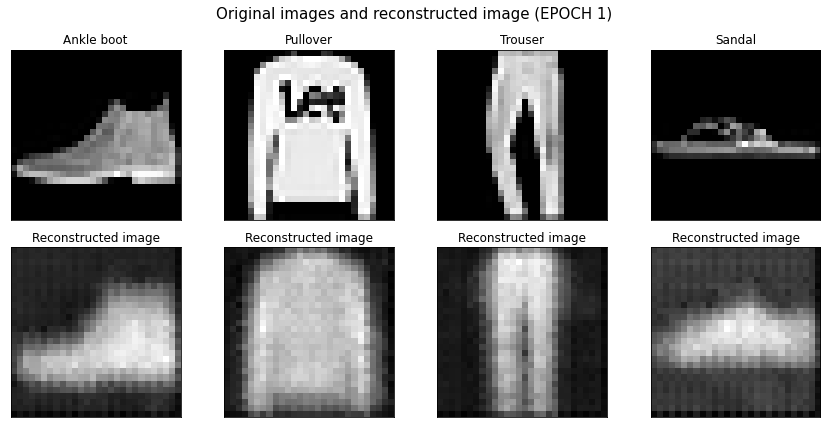

EPOCH 2/50
AVERAGE TRAIN LOSS: 0.026061495766043663
AVERAGE TEST LOSS: 0.023818019777536392
EPOCH 3/50
AVERAGE TRAIN LOSS: 0.022479118779301643
AVERAGE TEST LOSS: 0.021886726841330528
EPOCH 4/50
AVERAGE TRAIN LOSS: 0.02066550962626934
AVERAGE TEST LOSS: 0.020457953214645386
EPOCH 5/50
AVERAGE TRAIN LOSS: 0.019589465111494064
AVERAGE TEST LOSS: 0.019426977261900902
EPOCH 6/50
AVERAGE TRAIN LOSS: 0.018805259838700294
AVERAGE TEST LOSS: 0.01881447806954384


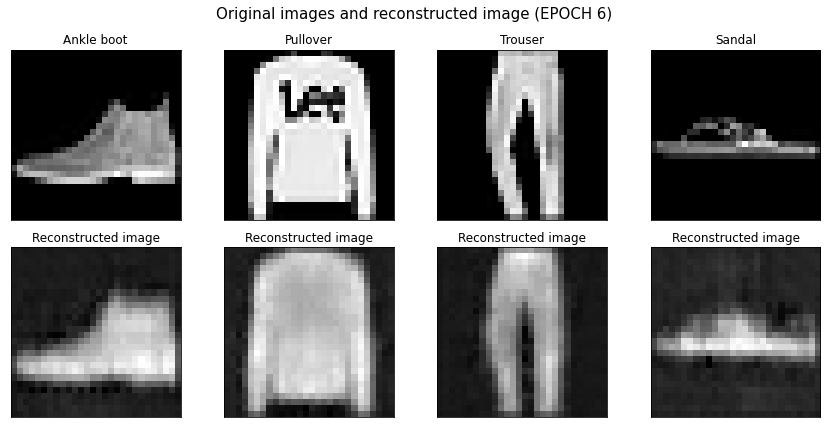

EPOCH 7/50
AVERAGE TRAIN LOSS: 0.018282264471054077
AVERAGE TEST LOSS: 0.018593410030007362
EPOCH 8/50
AVERAGE TRAIN LOSS: 0.01785062439739704
AVERAGE TEST LOSS: 0.01773875392973423
EPOCH 9/50
AVERAGE TRAIN LOSS: 0.01751028746366501
AVERAGE TEST LOSS: 0.0177933182567358
EPOCH 10/50
AVERAGE TRAIN LOSS: 0.01723489537835121
AVERAGE TEST LOSS: 0.017396388575434685
EPOCH 11/50
AVERAGE TRAIN LOSS: 0.017021141946315765
AVERAGE TEST LOSS: 0.017158737406134605


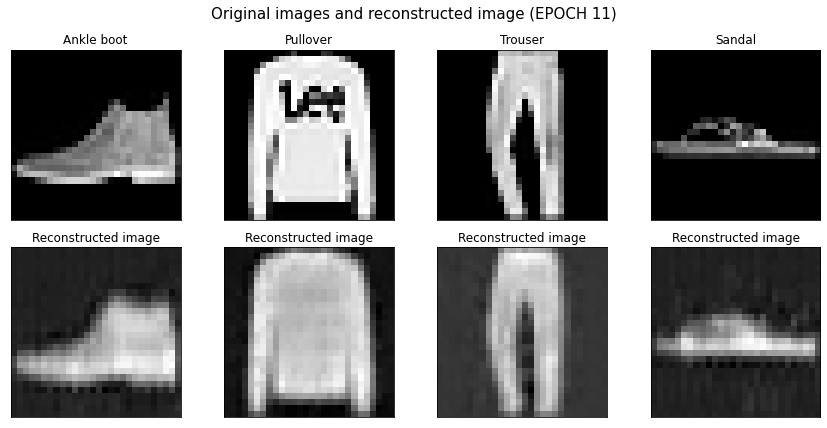

EPOCH 12/50
AVERAGE TRAIN LOSS: 0.01677996851503849
AVERAGE TEST LOSS: 0.016818635165691376
EPOCH 13/50
AVERAGE TRAIN LOSS: 0.016581280156970024
AVERAGE TEST LOSS: 0.01663806661963463
EPOCH 14/50
AVERAGE TRAIN LOSS: 0.016469456255435944
AVERAGE TEST LOSS: 0.016677815467119217
EPOCH 15/50
AVERAGE TRAIN LOSS: 0.016262630000710487
AVERAGE TEST LOSS: 0.016387874260544777
EPOCH 16/50
AVERAGE TRAIN LOSS: 0.016202542930841446
AVERAGE TEST LOSS: 0.016757117584347725


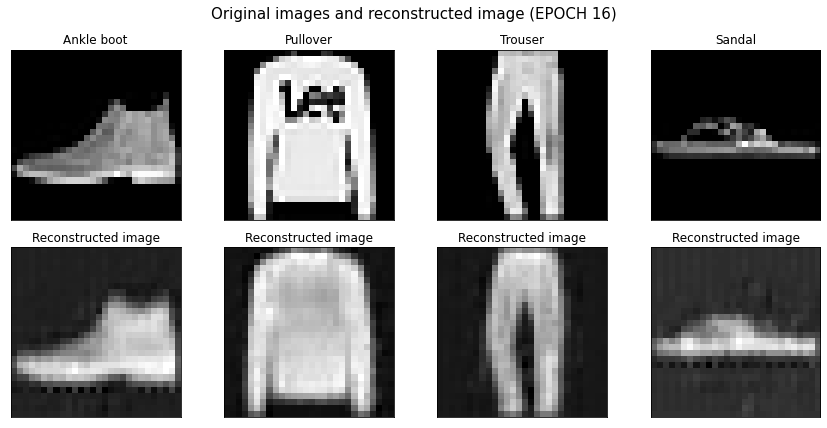

EPOCH 17/50
AVERAGE TRAIN LOSS: 0.01616661809384823
AVERAGE TEST LOSS: 0.016689658164978027
EPOCH 18/50
AVERAGE TRAIN LOSS: 0.01598455011844635
AVERAGE TEST LOSS: 0.016350891441106796
EPOCH 19/50
AVERAGE TRAIN LOSS: 0.01585337519645691
AVERAGE TEST LOSS: 0.015882235020399094
EPOCH 20/50
AVERAGE TRAIN LOSS: 0.01572532393038273
AVERAGE TEST LOSS: 0.016247261315584183
EPOCH 21/50
AVERAGE TRAIN LOSS: 0.01565612107515335
AVERAGE TEST LOSS: 0.015915069729089737


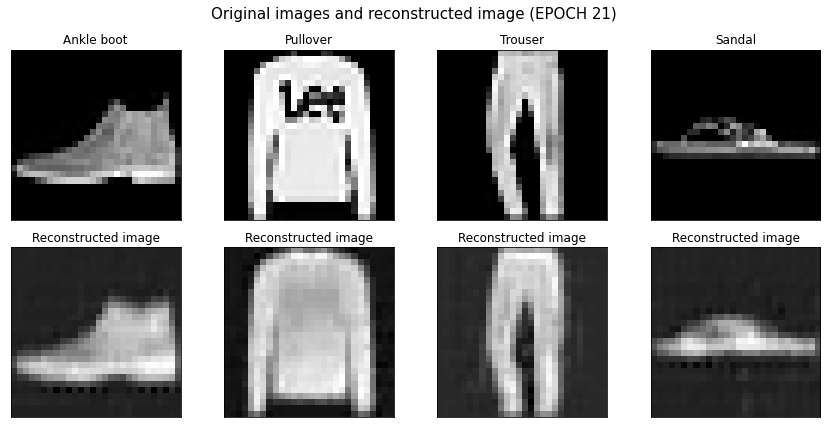

EPOCH 22/50
AVERAGE TRAIN LOSS: 0.015612462535500526
AVERAGE TEST LOSS: 0.015811529010534286
EPOCH 23/50
AVERAGE TRAIN LOSS: 0.015443524345755577
AVERAGE TEST LOSS: 0.01568826474249363
EPOCH 24/50
AVERAGE TRAIN LOSS: 0.015362276695668697
AVERAGE TEST LOSS: 0.01549039501696825
EPOCH 25/50
AVERAGE TRAIN LOSS: 0.015242255292832851
AVERAGE TEST LOSS: 0.0155349001288414
EPOCH 26/50
AVERAGE TRAIN LOSS: 0.017300397157669067
AVERAGE TEST LOSS: 0.015514028258621693


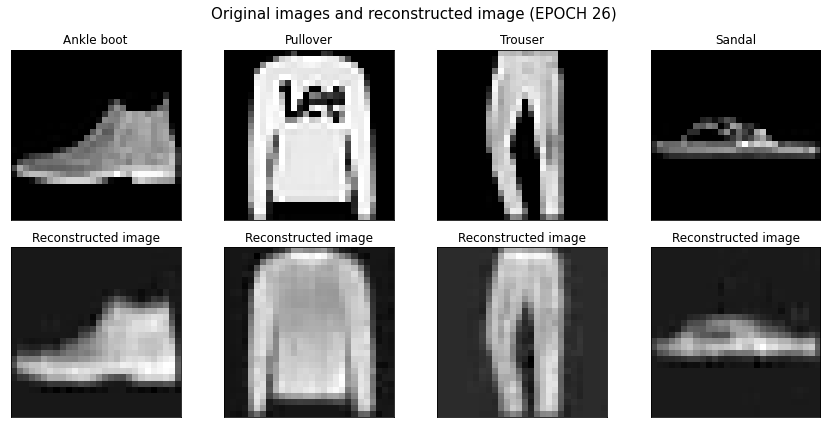

EPOCH 27/50
AVERAGE TRAIN LOSS: 0.015099180862307549
AVERAGE TEST LOSS: 0.015288705937564373
EPOCH 28/50
AVERAGE TRAIN LOSS: 0.015019995160400867
AVERAGE TEST LOSS: 0.015244657173752785
EPOCH 29/50
AVERAGE TRAIN LOSS: 0.014968464151024818
AVERAGE TEST LOSS: 0.015154266729950905
EPOCH 30/50
AVERAGE TRAIN LOSS: 0.014889489859342575
AVERAGE TEST LOSS: 0.015182377770543098
EPOCH 31/50
AVERAGE TRAIN LOSS: 0.014856904745101929
AVERAGE TEST LOSS: 0.015117352828383446


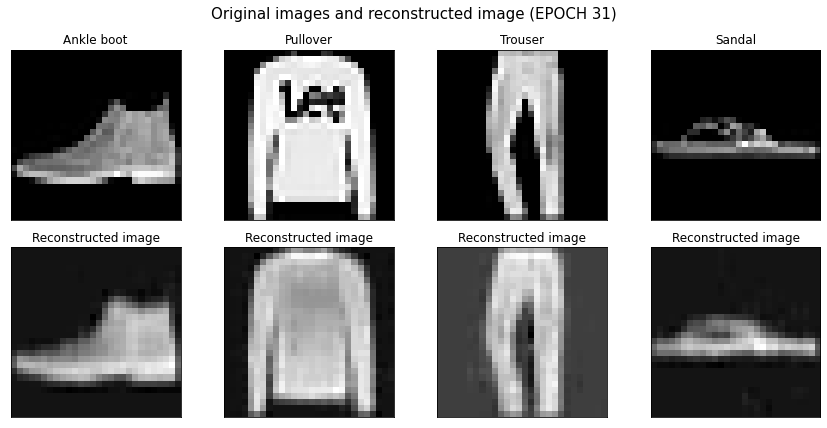

EPOCH 32/50
AVERAGE TRAIN LOSS: 0.014776441268622875
AVERAGE TEST LOSS: 0.015088222920894623
EPOCH 33/50
AVERAGE TRAIN LOSS: 0.014781341888010502
AVERAGE TEST LOSS: 0.015425925143063068
EPOCH 34/50
AVERAGE TRAIN LOSS: 0.014706729911267757
AVERAGE TEST LOSS: 0.015019552782177925
EPOCH 35/50
AVERAGE TRAIN LOSS: 0.014655313454568386
AVERAGE TEST LOSS: 0.014928525313735008
EPOCH 36/50
AVERAGE TRAIN LOSS: 0.014602635987102985
AVERAGE TEST LOSS: 0.014970692805945873


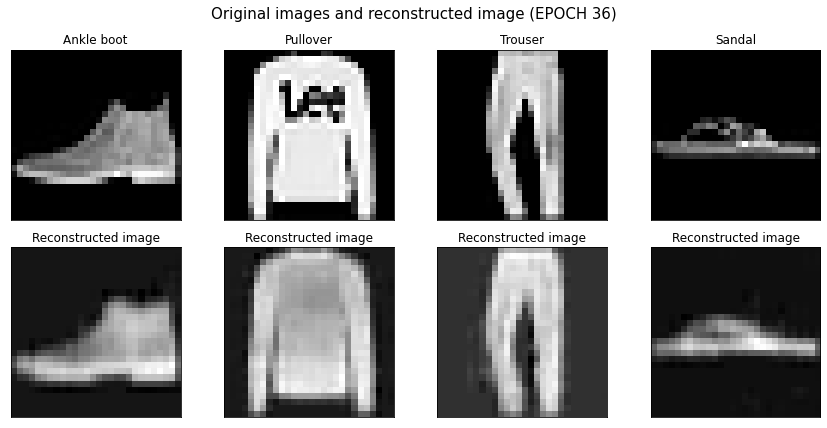

EPOCH 37/50
AVERAGE TRAIN LOSS: 0.014567847363650799
AVERAGE TEST LOSS: 0.015493487939238548
EPOCH 38/50
AVERAGE TRAIN LOSS: 0.014552491717040539
AVERAGE TEST LOSS: 0.014795574359595776
EPOCH 39/50
AVERAGE TRAIN LOSS: 0.014498891308903694
AVERAGE TEST LOSS: 0.014801537618041039
EPOCH 40/50
AVERAGE TRAIN LOSS: 0.014419659972190857
AVERAGE TEST LOSS: 0.01474776305258274
EPOCH 41/50
AVERAGE TRAIN LOSS: 0.01443153340369463
AVERAGE TEST LOSS: 0.014790348708629608


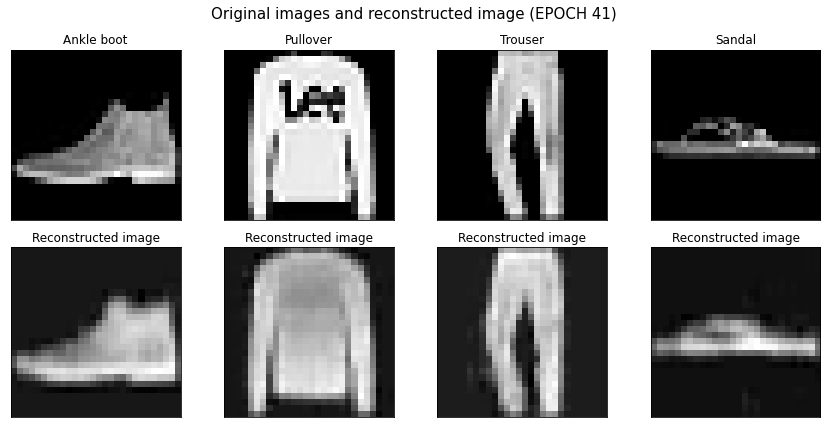

EPOCH 42/50
AVERAGE TRAIN LOSS: 0.014376478269696236
AVERAGE TEST LOSS: 0.014538693241775036
EPOCH 43/50
AVERAGE TRAIN LOSS: 0.014337007887661457
AVERAGE TEST LOSS: 0.01465363334864378
EPOCH 44/50
AVERAGE TRAIN LOSS: 0.014294818975031376
AVERAGE TEST LOSS: 0.014545753598213196
EPOCH 45/50
AVERAGE TRAIN LOSS: 0.014263280667364597
AVERAGE TEST LOSS: 0.014536199159920216
EPOCH 46/50
AVERAGE TRAIN LOSS: 0.014187742955982685
AVERAGE TEST LOSS: 0.014449539594352245


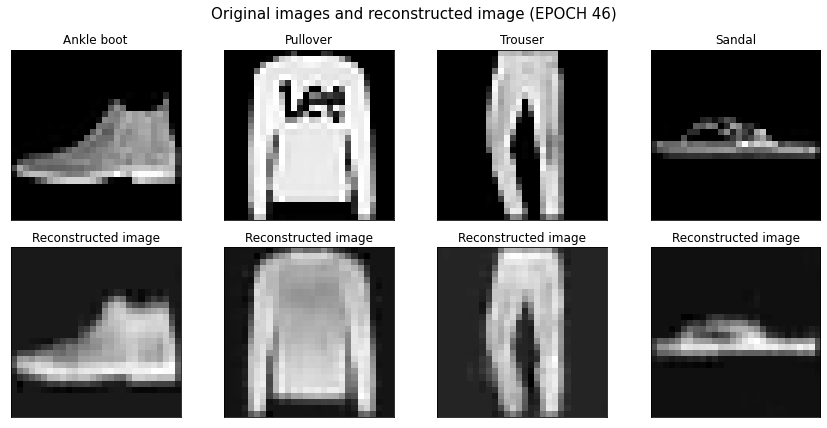

EPOCH 47/50
AVERAGE TRAIN LOSS: 0.014167959801852703
AVERAGE TEST LOSS: 0.014491111040115356
EPOCH 48/50
AVERAGE TRAIN LOSS: 0.014132572337985039
AVERAGE TEST LOSS: 0.014435986056923866
EPOCH 49/50
AVERAGE TRAIN LOSS: 0.014077004045248032
AVERAGE TEST LOSS: 0.014317100867629051
EPOCH 50/50
AVERAGE TRAIN LOSS: 0.01405677106231451
AVERAGE TEST LOSS: 0.01428629457950592


In [20]:
train, test = AE.training_cycle(AE.encoder,
                                AE.decoder,
                                device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optim,
                                n_epochs,
                                test_dataset,
                                plot = True)

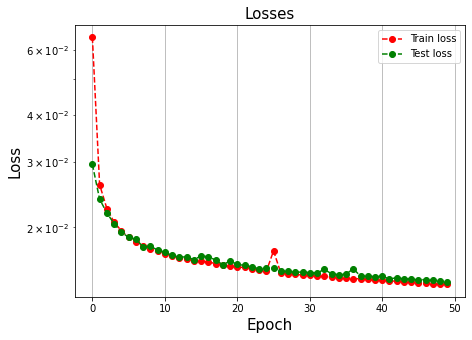

In [21]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

# Latent space exploration

## Retrieve the encoded vector for each image in the test set

In [22]:
# Load network parameters
AE.encoder.load_state_dict(torch.load('encoder_params.pth'))
AE.decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

In [23]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    AE.encoder.eval()
    with torch.no_grad():
        encoded_img  = AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:07<00:00, 1302.69it/s]


In [38]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            9.383063         7.181251        10.463519         7.901195   
1           22.556709       -20.761003         5.669639         4.805199   
2           15.748542       -12.306841        -0.035460         4.401807   
3            6.366249       -10.118771         0.140669         0.724178   
4           18.033144       -10.260003         2.256490        -4.014628   
...               ...              ...              ...              ...   
9995        17.442163        11.824389        17.020847        12.518579   
9996         3.427960        -7.118211        -0.316614         1.598015   
9997        14.852574       -14.117303        -7.835190        -7.876571   
9998         8.384076        -7.300735         5.740893         0.579951   
9999         8.756270         3.317082         3.483459         2.211201   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0            9.164447        -4.809511        -1.079639        -8.780399   
1            6.632806        -4.044245        -6.569039        26.496675   
2          -11.104590        -1.627466         8.116647         0.267729   
3           -8.249309         1.044195         9.957807         1.707808   
4           10.104614         3.182805        -2.363034        15.694970   
...               ...              ...              ...              ...   
9995        13.569005        -6.383499         7.753927         1.122046   
9996        -3.893604         2.730359         5.790360         0.918367   
9997         1.208330         0.272573        11.005821        -3.285685   
9998        -7.289689         3.340206         8.849006        -5.125963   
9999         4.959618        -4.524077        -5.204412        -4.726016   

      Enc. Variable 8  Enc. Variable 9  label  
0           -6.790045       -13.512802      9  
1           -2.043145       -12.048517      2  
2            7.641645        12.274415      1  
3            9.372795         5.661559      1  
4           -3.370970         0.494491      6  
...               ...              ...    ...  
9995        -9.749355       -14.986165      9  
9996         8.665716         3.549441      1  
9997        -4.690200        -6.843601      8  
9998        15.500491         5.873126      1  
9999        -1.125765        -4.902052      5  

[10000 rows x 11 columns]

## PCA

### 1d

In [74]:
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)


In [75]:
pca_df = pd.DataFrame(encoded_samples_reduced_PCA)
pca_df['label'] = encoded_samples.label 


In [77]:
import plotly.express as px
px.scatter(pca_df, x=0, y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
plt.savefig('TSNE_CAE.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

### 3d

In [62]:
pca = PCA(n_components=3)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)

In [63]:
pca3d_df = pd.DataFrame(encoded_samples_reduced_PCA)
pca3d_df['label'] = encoded_samples.label

In [66]:
fig = px.scatter_3d(pca3d_df, x=0, y=1,z=2, color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)
fig.show()

## TSNE

### 2d

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)


C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [61]:
tsne_df = pd.DataFrame(encoded_samples_reduced_TSNE)
tsne_df['label'] = encoded_samples.label 


In [60]:
px.scatter(tsne_df, x=0, y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

### 3d

In [67]:
tsne = TSNE(n_components=3)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [68]:
tsne3d_df = pd.DataFrame(encoded_samples_reduced_TSNE)
tsne3d_df['label'] = encoded_samples.label 

In [72]:
fig = px.scatter_3d(tsne3d_df, x=0, y=1,z=2, color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.5)
fig.show()

# Denoising and Sample generation

# Convolutional autoencoder fine tuning

## Data

In [24]:
#Define a validation dataset
train_percent = 0.7
n_train      = int(train_percent * len(train_dataset))
n_validation = len(train_dataset) - n_train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

print('# of training samples  :',len(train_dataset))
print('# of validation samples:',len(val_dataset))
print('# of test samples      :',len(test_dataset))


# of training samples  : 42000
# of validation samples: 18000
# of test samples      : 10000


In [25]:
batch_size = 256
train_dataloader      = DataLoader(train_dataset,  batch_size=batch_size,        shuffle=True, num_workers=0)
validation_dataloader = DataLoader(val_dataset,    batch_size=len(val_dataset),  shuffle=False, num_workers=0)
test_dataloader       = DataLoader(test_dataset,   batch_size=len(test_dataset), shuffle=False, num_workers=0)


## Transfer the autoencoder encoder weights to the supervised network

In [26]:
encoded_space_dim = trial.params["encoded_space_dim"]

In [27]:
# Initialize the old autoencoder
AE = model.Autoencoder(encoded_space_dim)
# Load network parameters
AE.encoder.load_state_dict(torch.load('encoder_params.pth'))

<All keys matched successfully>

In [28]:
#Initialize the Autoencoder for fine tuning
FTAE = model.Fine_Tuned_Autoencoder(encoded_space_dim,AE)


In [29]:
FTAE

Fine_Tuned_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
  (new_layer): Linear(in_features=10, out_features=10, bias=True)
)

In [30]:
### Disable the weight update for the trained encoder
for param_name, param in FTAE.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[7].parameters():
    param.requires_grad = True
    
### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[9].parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in FTAE.encoder.named_parameters():
    print(param_name,param.requires_grad)

0.weight False
0.bias False
2.weight False
2.bias False
4.weight False
4.bias False
7.weight True
7.bias True
9.weight True
9.bias True


In [31]:
learning_rate       = 1e-3
regularization_term = 0.
n_epochs = 50

In [32]:
### Define the loss function
loss_fn = nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': FTAE.encoder.parameters()},
    {'params': FTAE.new_layer.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization_term)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [33]:
train, test = FTAE.tune_training_cycle(FTAE.encoder,
                                       FTAE.new_layer,
                                       device,
                                       train_dataloader,
                                       validation_dataloader,
                                       loss_fn,
                                       optim,
                                       n_epochs,
                                       test_dataloader)

EPOCH 1/50
AVERAGE TRAIN LOSS: 1.0762829780578613
AVERAGE VALIDATION LOSS: 0.6087895035743713
EPOCH 2/50
AVERAGE TRAIN LOSS: 0.5611067414283752
AVERAGE VALIDATION LOSS: 0.5280892252922058
EPOCH 3/50
AVERAGE TRAIN LOSS: 0.5001186728477478
AVERAGE VALIDATION LOSS: 0.47759804129600525
EPOCH 4/50
AVERAGE TRAIN LOSS: 0.4621883034706116
AVERAGE VALIDATION LOSS: 0.4594845473766327
EPOCH 5/50
AVERAGE TRAIN LOSS: 0.43588659167289734
AVERAGE VALIDATION LOSS: 0.4381653070449829
EPOCH 6/50
AVERAGE TRAIN LOSS: 0.41518351435661316
AVERAGE VALIDATION LOSS: 0.4183076024055481
EPOCH 7/50
AVERAGE TRAIN LOSS: 0.40601515769958496
AVERAGE VALIDATION LOSS: 0.411470890045166
EPOCH 8/50
AVERAGE TRAIN LOSS: 0.3915849030017853
AVERAGE VALIDATION LOSS: 0.405600368976593
EPOCH 9/50
AVERAGE TRAIN LOSS: 0.3833042085170746
AVERAGE VALIDATION LOSS: 0.4115559458732605
EPOCH 10/50
AVERAGE TRAIN LOSS: 0.3735819458961487
AVERAGE VALIDATION LOSS: 0.39413896203041077
EPOCH 11/50
AVERAGE TRAIN LOSS: 0.37093687057495117
AVER

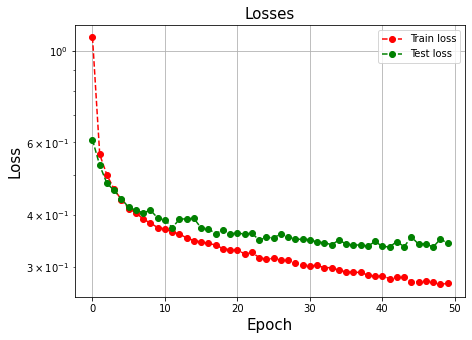

In [34]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Test loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.ylim(0,2)
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

In [35]:
test_acc = 0

y_test=[]
y_pred=[]

FTAE.encoder.to(device)
#move the input to the GPU and predict the output
FTAE.encoder.eval()
FTAE.new_layer.eval()

with torch.no_grad():
    for x_batched, y_batched in test_dataloader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)

        # Encode the data
        z   = FTAE.encoder(x_batched)
        out = FTAE.new_layer(z)

        y_test.append(y_batched)
        y_pred.append(out)

        pred = np.argmax(out.detach().cpu().numpy(), axis = 1)
        right = np.sum(pred == np.array(y_batched.cpu()))
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(test_dataset)*100} %")

The obtained accuracy is 87.21 %


In [36]:
def confussion_plot(real, prediction):
    categories = ['T-shirt/top','Trouser','Pullover',
                    'Dress','Coat','Sandal','Shirt',
                    'Sneaker','Bag','Ankle boot']

    array = confusion_matrix(real, prediction,normalize="true")
    df_cm = pd.DataFrame(array, index = categories, columns = categories)
    
    fig = plt.figure(figsize=(8,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f')
    plt.ylabel("Correct",fontsize=15)
    plt.xlabel("Predicted",fontsize=15)
    plt.title("Confussion matrix",fontsize=15)
    #plt.savefig('./imgs/classification/confussion.svg', format='svg')
    plt.show()

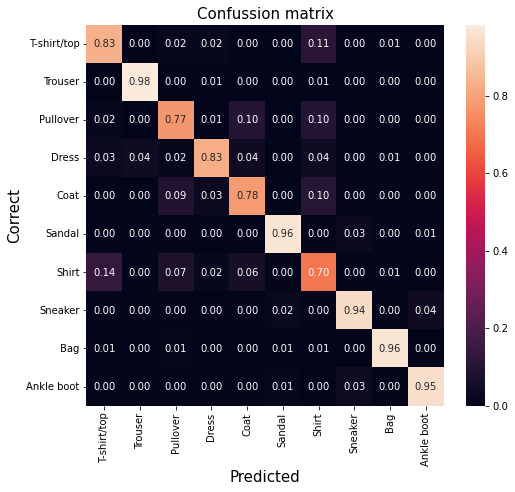

In [37]:
confussion_plot(y_batched, pred)